
Hackaton: Urban Air Pollution Challenge 
=============================================
Edimer David Jaramillo   
Abril de 2020

## Instalando y cargando bibliotecas

In [0]:
install.packages("h2o", dependencies = TRUE)
library(tidyverse)
library(h2o)
library(data.table)

## Importando datos

In [0]:
df_test <- fread("/content/Test3_sin_impute.csv")
df_train <- fread("/content/Train3_sin_impute.csv")

nombres_train <- fread("/content/nombres_python2.csv")
nombres_test <- fread("/content/nombres_python_test2.csv")

nombres_train1 <- names(df_train)
nombres_train1[54] <- "histograma"
names(df_train) <- nombres_train1

nombres_test1 <- names(df_test)
nombres_test1[56] <- "histograma"
names(df_test) <- nombres_test1

## Modelo XGBoost

In [25]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Train y Test h2o
df_train <- df_train %>% 
  mutate(target = log(target))

# Datos h2o
datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.8, 0.10),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_H2O")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_H2O")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_H2O")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

# Modelo XGB h2o
xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb_model_35"
                  ,stopping_rounds = 5
                  ,stopping_metric = "RMSE"
                  ,distribution = "gaussian"
                  ,score_tree_interval = 1
                  ,learn_rate=0.05
                  ,ntrees=5000
                  ,subsample = 0.9
                  ,colsample_bytree = 1
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 1,
                  ,max_runtime_secs = 3600
                  ,nfolds = 10,
                  ,seed = 123,
                  max_depth = 10,
                  min_rows = 8)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         9 minutes 30 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    9 days  
    H2O cluster name:           H2O_started_from_R_root_qcs008 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   10.00 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 

  |======================================================================| 100%
  |======================================================================| 

In [26]:
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb_model_35 
Model Summary: 
  number_of_trees
1             116


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.1351957
RMSE:  0.3676897
MAE:  0.2773485
RMSLE:  0.09241686
Mean Residual Deviance :  0.1351957


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  0.2864671
RMSE:  0.5352262
MAE:  0.4020481
RMSLE:  0.1254293
Mean Residual Deviance :  0.2864671


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.2964758
RMSE:  0.5444959
MAE:  0.4085232
RMSLE:  0.1319137
Mean Residual Deviance :  0.2964758


Cross-Validation Metrics Summary: 
                             mean           sd cv_1_valid cv_2_valid
mae                     0.4085446 0.0072393185 0.41363025  0.4047874
mean_residual_deviance 0.29654634  0.015561931  0.3166508 0.28894287
mse              

## Predicciones

In [27]:
# ============================= Predicciones ====================================== #

# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(df_test)) %>%
  as.data.frame() %>% pull(predict) %>% exp()
df_test %>% 
  select(`Place_ID X Date`) %>% 
  mutate(target = predichos_subm) ->
  subm39

# Exportando predicciones
write.csv(subm39, file = "subm39.csv", row.names = FALSE)

RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


data,RMSE
<fct>,<dbl>
Train,0.3676897
Test,0.5650134


  |======================================================================| 100%


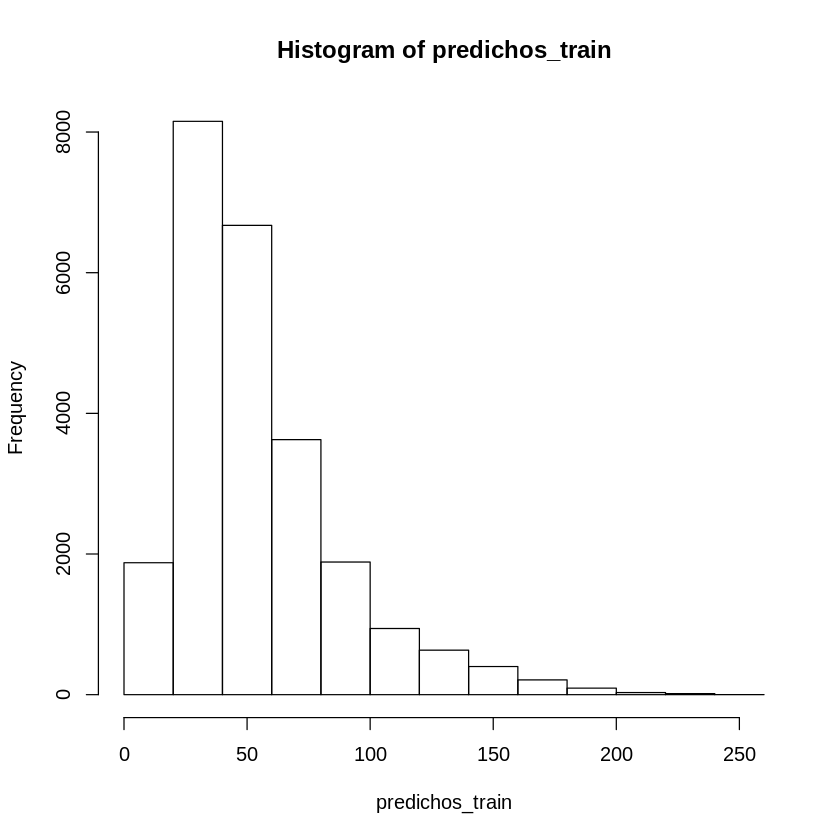

In [29]:
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict) %>% exp()
hist(predichos_train)

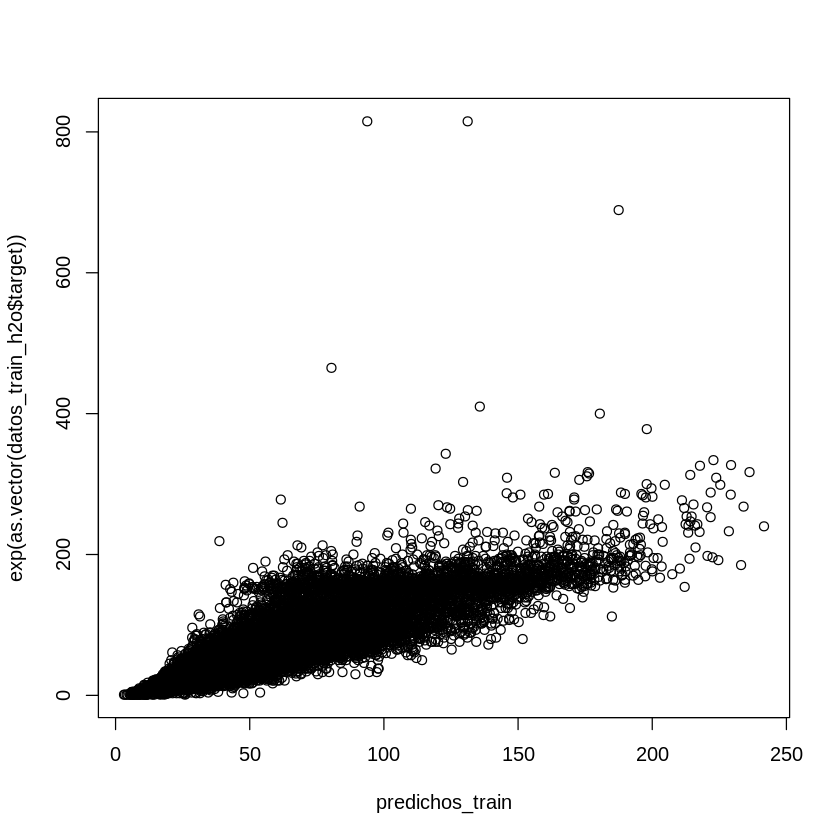

In [31]:
plot(predichos_train, exp(as.vector(datos_train_h2o$target)))

  |======================================================================| 100%


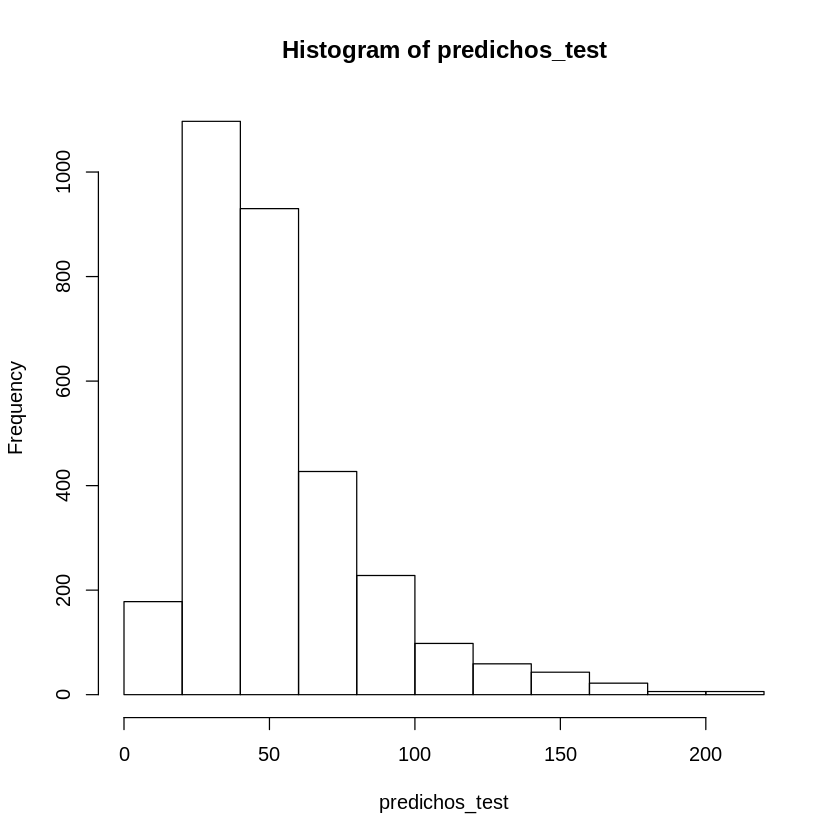

In [32]:
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict) %>% exp()
hist(predichos_test)

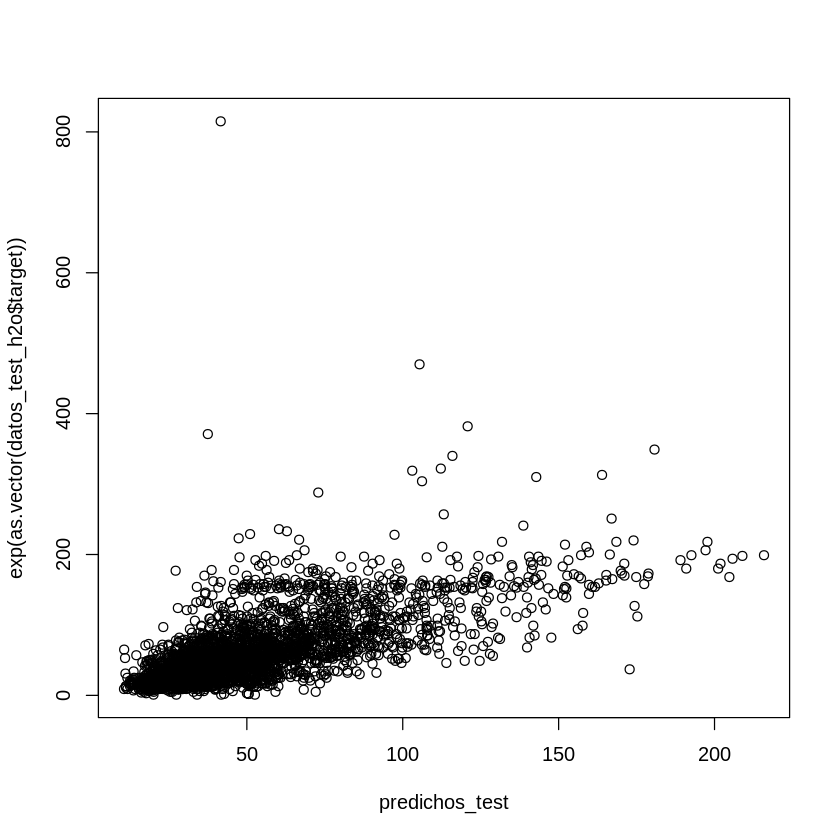

In [33]:
plot(predichos_test, exp(as.vector(datos_test_h2o$target)))

  |======================================================================| 100%
  |======================================================================| 100%


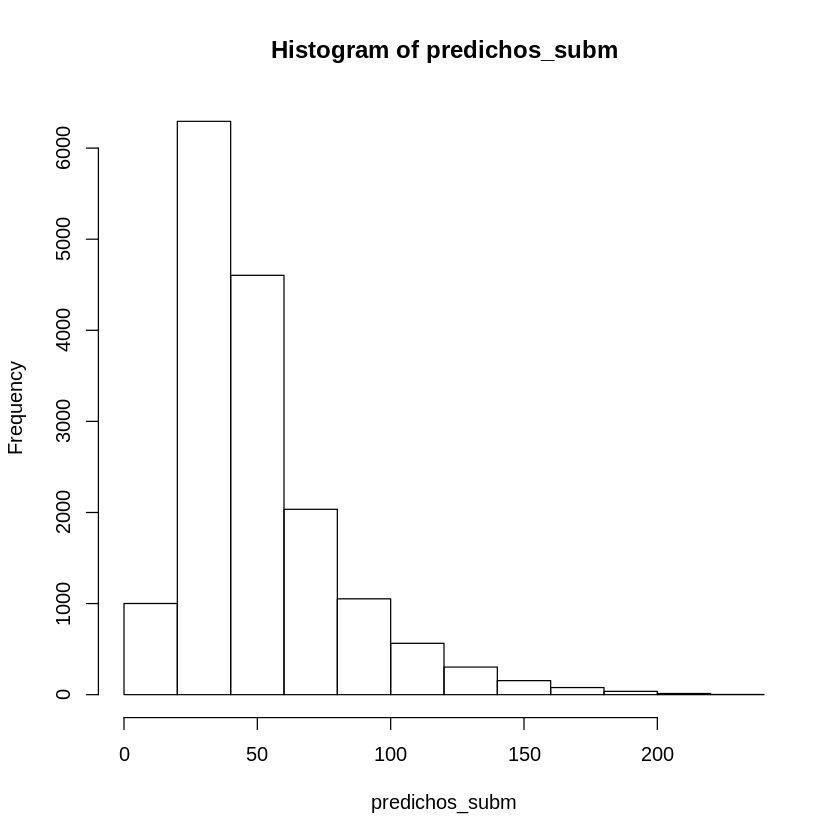

In [35]:
predichos_subm <- h2o.predict(xgb, as.h2o(df_test)) %>%
  as.data.frame() %>% pull(predict) %>% exp()
hist(predichos_subm)

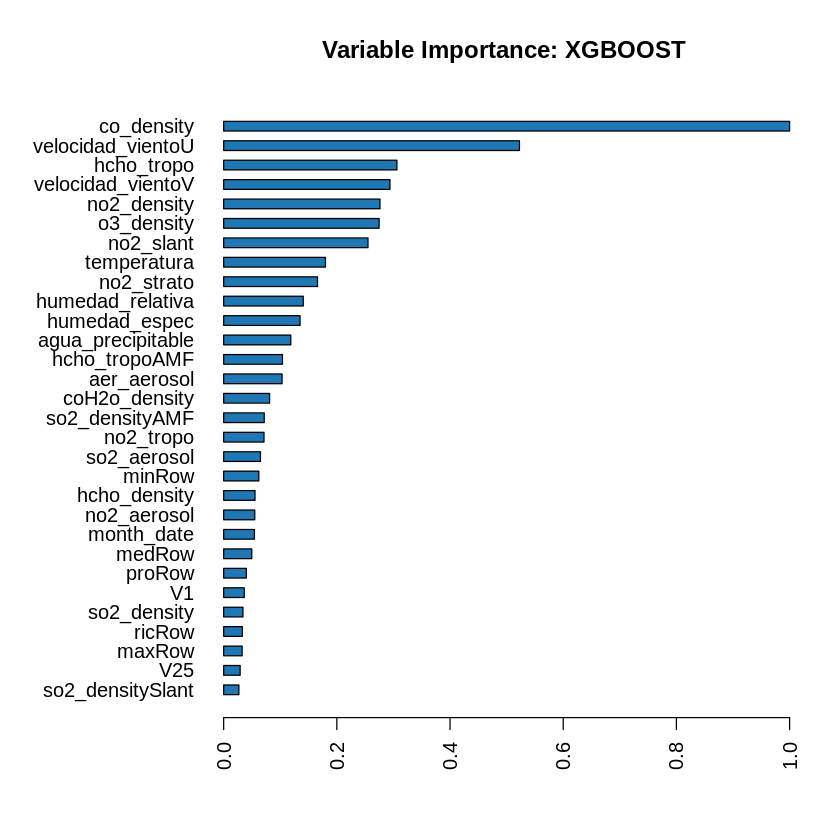

In [36]:
h2o.varimp_plot(xgb, num_of_features = 30)

In [0]:
h2o.saveModel(xgb, path = "XGB_Subm57", force = TRUE)

In [0]:
h2o.shutdown()